In [1]:
!pip install transformers
!pip install sentence_transformers
!pip install datasets
!pip install git+https://github.com/huggingface/accelerate.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.5/156.5 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 19.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 28.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 22.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn import metrics as m

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sentence_transformers import SentenceTransformer
from transformers import BertForSequenceClassification, BertTokenizer, AutoModel, TrainingArguments, Trainer
from transformers import RobertaForMaskedLM,RobertaTokenizer, pipeline
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from pathlib import Path
from datasets import Dataset, ClassLabel, load_metric
from wordcloud import WordCloud
from torch.nn import Sigmoid
import torch
device = torch.device('cuda')
from sklearn.metrics import classification_report,  roc_auc_score, confusion_matrix


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')
# df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/1t/datasets/df_pp_stem_lemm.csv")
# df = df.drop('Unnamed: 0',axis=1)
# df.shape

ModuleNotFoundError: No module named 'google.colab'

In [ ]:
file_path = Path("G:/Мой диск/Colab Notebooks/1t/Attractor/datasets/df_pp_stem_lemm.csv")
df = pd.read_csv(file_path)
df = df.drop('Unnamed: 0', axis=1)
print(df.shape)

(3184, 12)


In [ ]:
# # 711 mb
model_rubertb = AutoModelForSequenceClassification.from_pretrained('s-nlp/rubert-base-cased-conversational-paraphrase-v1')
tokenizer_rubertb = AutoTokenizer.from_pretrained('s-nlp/rubert-base-cased-conversational-paraphrase-v1')



# ПОРОБОВАТЬ в КАЛАБЕ

# 1.42 Gb
# model_ruRobertaLv1 = RobertaForMaskedLM.from_pretrained('s-nlp/ruRoberta-large-paraphrase-v1', num_labels=df['sentiment'].nunique())
# tokenizer_ruRobertaLv1 = RobertaTokenizer.from_pretrained('s-nlp/ruRoberta-large-paraphrase-v1')

# 1.42 Gb
# model_ruRobertaL = RobertaForMaskedLM.from_pretrained('sberbank-ai/ruRoberta-large', num_labels=df['sentiment'].nunique())
# tokenizer_ruRobertaL = RobertaTokenizer.from_pretrained('sberbank-ai/ruRoberta-large')

# !!!!!!!!!!!!! Модели очень  большие  для моего ноута !!!!!!!!!


# unmasker = pipeline('fill-mask', model=model,tokenizer=tokenizer)
# unmasker("Стоит чаще писать на Хабр про <mask>.")


In [ ]:
model = model_rubertb
tokenizer = tokenizer_rubertb

<Axes: >

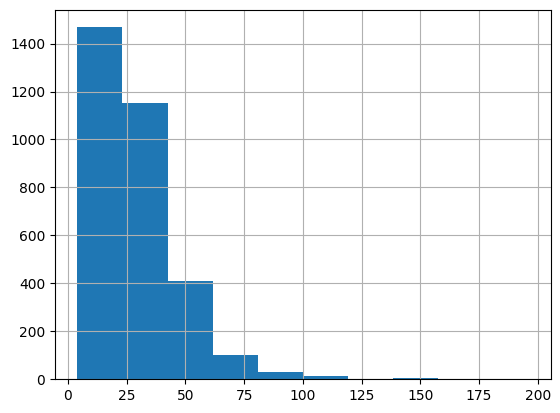

In [ ]:
df['name'].apply(lambda x: len(tokenizer.encode(x))).hist()

In [ ]:
data = Dataset.from_pandas(df)
data = data.class_encode_column("sentiment") # для  возможности применения stratify_by_column
data = data.train_test_split(test_size=0.2, stratify_by_column='sentiment', seed=42)

Stringifying the column:   0%|          | 0/3184 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/3184 [00:00<?, ? examples/s]

In [ ]:
def tokenize_function(row):
    return tokenizer(row['name'],
              truncation=True,
              max_length=100,
              padding='max_length')

train = data['train'].map(tokenize_function, batched=True)
test = data['test'].map(tokenize_function, batched=True)

train = train.rename_column("sentiment", "label")
test = test.rename_column("sentiment", "label")

Map:   0%|          | 0/2547 [00:00<?, ? examples/s]

Map:   0%|          | 0/637 [00:00<?, ? examples/s]

In [ ]:
metric = load_metric('accuracy')

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return metric.compute(predictions=predictions, references=labels)

/usr/local/lib/python3.10/dist-packages/datasets/load.py:756: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.18.0/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


In [ ]:
# def calculate_class_weights(df, target_column):
#     classes = np.unique(df[target_column])
#     class_weights = compute_class_weight('balanced', classes=classes, y=df[target_column])
#     weights_tensor = torch.tensor(class_weights, dtype=torch.float)
#     return weights_tensor

In [ ]:
# def compute_loss_with_class_weights(pred, class_weights):
#     logits = pred.predictions
#     targets = pred.label_ids

#     # Применяем веса классов к потерям с использованием взвешенной кросс-энтропии
#     loss_fct = torch.nn.CrossEntropyLoss(weight=class_weights)
#     loss = loss_fct(logits.view(-1, logits.shape[-1]), targets.view(-1))

#     return loss

In [ ]:
training_args = TrainingArguments(output_dir="temp",
                                  evaluation_strategy="epoch",
                                  num_train_epochs=5,
                                  save_steps=200,
                                  per_device_eval_batch_size=64,
                                  per_device_train_batch_size=64,
                                  report_to='none')


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train,
    eval_dataset={"TRAIN": train, "VALID": test},
    compute_metrics=compute_metrics
)


/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Train Loss,Train Accuracy,Valid Loss,Valid Accuracy
1,No log,No log,0.084369,0.968198,0.129185,0.954474
2,No log,No log,0.044008,0.986258,0.143113,0.948195
3,No log,No log,0.022007,0.992933,0.163934,0.956044
4,No log,No log,0.006761,0.997252,0.193194,0.957614
5,No log,No log,0.002292,0.999215,0.209626,0.948195


TrainOutput(global_step=200, training_loss=0.0853774356842041, metrics={'train_runtime': 306.1646, 'train_samples_per_second': 41.595, 'train_steps_per_second': 0.653, 'total_flos': 654437361330000.0, 'train_loss': 0.0853774356842041, 'epoch': 5.0})

In [ ]:
# сохраняем веса
tokenizer.save_pretrained('/content/drive/MyDrive/Colab Notebooks/1t/nlp_models/saved_weights_tokenizer_rubert-base-cased-conversational-paraphrase-v1.pt')
model.save_pretrained('/content/drive/MyDrive/Colab Notebooks/1t/nlp_models/saved_weights_model_rubert-base-cased-conversational-paraphrase-v1.pt')

In [ ]:
preds = trainer.predict(test)

In [ ]:
threshold = 0.5

test_probas = torch.sigmoid(torch.from_numpy(preds.predictions[:, 1]))

test_labels = test_probas.numpy() > threshold
test_labels = test_labels.tolist()

print(m.classification_report(test['label'], test_labels))

roc_auc = roc_auc_score(test['label'], test_probas)
print(f"ROC-AUC: {roc_auc}")

conf_matrix = confusion_matrix(test['label'], test_labels)
print("Confusion Matrix:")
print(conf_matrix)

              precision    recall  f1-score   support

           0       0.97      0.97      0.97       589
           1       0.66      0.65      0.65        48

    accuracy                           0.95       637
   macro avg       0.82      0.81      0.81       637
weighted avg       0.95      0.95      0.95       637

ROC-AUC: 0.9666454442558008
Confusion Matrix:
[[573  16]
 [ 17  31]]


In [ ]:
# sns.histplot(test_probas, hue=test['label'])

-----

Пробуем прокинуть веса классов

In [ ]:
class_weights = compute_class_weight('balanced', classes=np.unique(train['label']), y=train['label'])
print(class_weights)
weights = torch.tensor(class_weights, dtype=torch.float)

[0.5405348  6.66753927]


In [ ]:
from torch import nn
from transformers import Trainer


class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels")
        # forward pass
        outputs = model(**inputs)
        logits = outputs.get("logits")
        # loss_fct = nn.CrossEntropyLoss(weight=torch.tensor([6.66753927, 0.5405348], device=model.device))
        loss_fct = nn.CrossEntropyLoss(weight=torch.tensor(weights, device=model.device))
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

In [ ]:
training_args = TrainingArguments(output_dir="temp",
                                  evaluation_strategy="epoch",
                                  num_train_epochs=5,
                                  save_steps=200,
                                  per_device_eval_batch_size=64,
                                  per_device_train_batch_size=64,
                                  report_to='none')


trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train,
    eval_dataset={"TRAIN": train, "VALID": test},
    compute_metrics=compute_metrics
)

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [ ]:
trainer.train()

<ipython-input-56-23a28b197067>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss_fct = nn.CrossEntropyLoss(weight=torch.tensor(weights, device=model.device))


Epoch,Training Loss,Validation Loss,Train Loss,Train Accuracy,Valid Loss,Valid Accuracy
1,No log,No log,0.089475,0.995289,1.536282,0.937206
2,No log,No log,0.099981,0.995681,1.942714,0.940345
3,No log,No log,0.002254,0.999607,1.293240,0.945055
4,No log,No log,0.011405,0.999607,1.621637,0.948195
5,No log,No log,0.004073,0.999607,1.632276,0.949765


<ipython-input-56-23a28b197067>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss_fct = nn.CrossEntropyLoss(weight=torch.tensor(weights, device=model.device))
<ipython-input-56-23a28b197067>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss_fct = nn.CrossEntropyLoss(weight=torch.tensor(weights, device=model.device))
<ipython-input-56-23a28b197067>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss_fct = nn.CrossEntropyLoss(weight=torch.tensor(weights, device=model.device))
<ipython-input-56-23a28b197067>:13: UserWarning: To 

TrainOutput(global_step=200, training_loss=0.05518048286437988, metrics={'train_runtime': 297.6065, 'train_samples_per_second': 42.791, 'train_steps_per_second': 0.672, 'total_flos': 654437361330000.0, 'train_loss': 0.05518048286437988, 'epoch': 5.0})

In [ ]:
preds = trainer.predict(test)

<ipython-input-56-23a28b197067>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss_fct = nn.CrossEntropyLoss(weight=torch.tensor(weights, device=model.device))


In [ ]:
threshold = 0.25

test_probas = torch.sigmoid(torch.from_numpy(preds.predictions[:, 1]))

test_labels = test_probas.numpy() > threshold
test_labels = test_labels.tolist()

print(m.classification_report(test['label'], test_labels))

roc_auc = roc_auc_score(test['label'], test_probas)
print(f"ROC-AUC: {roc_auc}")

conf_matrix = confusion_matrix(test['label'], test_labels)
print("Confusion Matrix:")
print(conf_matrix)

              precision    recall  f1-score   support

           0       0.97      0.97      0.97       589
           1       0.63      0.65      0.64        48

    accuracy                           0.95       637
   macro avg       0.80      0.81      0.80       637
weighted avg       0.95      0.95      0.95       637

ROC-AUC: 0.9598189020939445
Confusion Matrix:
[[571  18]
 [ 17  31]]


---- СТАЛО ХУЖЕ !!

---------

# Предиктим


In [2]:
!pip install transformers sentencepiece sacremoses

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 9.3 MB/s eta 0:00:00


In [3]:
import pandas as pd
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn import metrics as m

from sentence_transformers import SentenceTransformer, util
from transformers import BertForSequenceClassification, BertTokenizer, BertModel, TrainingArguments, Trainer
from transformers import RobertaForMaskedLM,RobertaTokenizer, pipeline
from transformers import AutoModelForSequenceClassification, AutoTokenizer, AutoModel


from datasets import Dataset, ClassLabel, load_metric
from wordcloud import WordCloud
from torch.nn import Sigmoid
import torch
import torch.nn.functional as f # the sub-library containing different functions for manipulating with tensors
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import os
import pickle

импорт Датасета

In [5]:
from google.colab import drive
drive.mount('/content/drive')
file_path = Path("/content/drive/MyDrive/Colab Notebooks/1t/Attractor/datasets/df_24.csv")
# file_path = Path("G:/Мой диск/Colab Notebooks/1t/Attractor/datasets/df_24.csv")

df = pd.read_csv(file_path)
df = df.drop('Unnamed: 0', axis=1)
print(df.shape)

Mounted at /content/drive
(11667, 3)


In [6]:
df['ord_title'].isnull().sum()

37

In [7]:
# дропаем NAN а то ничего не полетит
df.dropna(inplace=True)
data = Dataset.from_pandas(df)

In [8]:
df.head(4)

,ord_id,ord_no,ord_title
0,1,834500001724000013,Услуги по передаче прав на программное обеспеч...
1,2,132200000124000006,Оказание услуг по предоставлению лицензий на п...
2,3,390100006724000018,Продление ранее закупленных неисключительных п...
3,4,311100021124000003,Услуги по передаче неисключительных прав испол...


In [9]:
df.rename(columns={'ord_title': 'text'}, inplace=True)

In [10]:
# FOR COLAB
# from google.colab import drive
# drive.mount('/content/drive')
tokenizer_path = Path("/content/drive/MyDrive/Colab Notebooks/1t/Attractor/model/Kriv/nlp/rubert/saved_weights_tokenizer_rubert-base-cased-conversational-paraphrase-v1.pt")
model_path = Path('/content/drive/MyDrive/Colab Notebooks/1t/Attractor/model/Kriv/nlp/rubert/saved_weights_model_rubert-base-cased-conversational-paraphrase-v1.pt')

# LOCAL
# tokenizer_path = Path("G:/Мой диск/Colab Notebooks/1t/Attractor/model/Kriv/nlp/rubert/saved_weights_tokenizer_rubert-base-cased-conversational-paraphrase-v1.pt")
# model_path = Path('G:/Мой диск/Colab Notebooks/1t/Attractor/model/Kriv/nlp/rubert/saved_weights_model_rubert-base-cased-conversational-paraphrase-v1.pt')

tokenizer = BertTokenizer.from_pretrained(tokenizer_path)
model = BertForSequenceClassification.from_pretrained(model_path)

model = model.to(device)

# pipeline
available tasks are \
['audio-classification', 'automatic-speech-recognition', 'conversational', 'depth-estimation', 'document-question-answering', 'feature-extraction', 'fill-mask', 'image-classification', 'image-feature-extraction', 'image-segmentation', 'image-to-image', 'image-to-text', 'mask-generation', 'ner', 'object-detection', 'question-answering', 'sentiment-analysis', 'summarization', 'table-question-answering', 'text-classification', 'text-generation', 'text-to-audio', 'text-to-speech', 'text2text-generation', 'token-classification', 'translation', 'video-classification', 'visual-question-answering', 'vqa', 'zero-shot-audio-classification', 'zero-shot-classification', 'zero-shot-image-classification', 'zero-shot-object-detection', 'translation_XX_to_YY']

In [ ]:
# def predict(model, tokenizer, test_dataset, id2label, save_data_folder_path, service_col_name='text'):

#     pipe = pipeline("text-classification", model=model, tokenizer=tokenizer, framework='pt', device=0)
#     preds = [int(float(pipe(row[service_col_name])[0]['label'])) for index, row in test_dataset.iterrows()]
#     preds = list(map(lambda x: id2label[x], preds))
#     test_dataset['preds'] = preds
#     test_dataset.to_json(os.path.join(save_data_folder_path, 'predict.json'), orient='records')
#     return preds, test_dataset
# id2label = {0: '0', 1: '1'}
# predictions, df_with_preds = predict(model, tokenizer, df, id2label, "путь_к_папке_для_сохранения_результатов")

# print("Предсказания:", predictions)
# print("Датасет с предсказаниями:")
# print(df_with_preds)

In [ ]:
# id2label = {0: '0', 1: '1'}
# def predict(model, tokenizer, test_dataset, id2label, save_data_folder_path, service_col_name='text'):
#     pipe = pipeline("text-classification", model=model, tokenizer=tokenizer, framework='pt', device=0)
#     preds = [pipe(row[service_col_name])[0]['label'] for index, row in test_dataset.iterrows()]
#     preds = list(map(lambda x: id2label[x], preds))
#     test_dataset['preds'] = preds
#     test_dataset.to_json(os.path.join(save_data_folder_path, 'predict.json'), orient='records')
#     return preds, test_dataset


# predictions, df_with_preds = predict(model, tokenizer, df, id2label, "путь_к_папке_для_сохранения_результатов")


In [ ]:
# print("Предсказания:", predictions)
# print("Датасет с предсказаниями:")
# print(df_with_preds)

In [12]:
id2label = {0: '0', 1: '1'}

In [14]:
def predict(model, tokenizer, test_dataset, id2label, service_col_name='text'):
    pipe = pipeline("text-classification", model=model, tokenizer=tokenizer, framework='pt', device=0)
    preds = []
    for index, row in test_dataset.iterrows():
        prediction = pipe(row[service_col_name])[0]['label']
        if prediction in id2label:
            preds.append(id2label[prediction])
        else:
            preds.append('Unknown')  # Замените на соответствующее действие для неизвестной метки
    test_dataset['preds'] = preds
    save_data_folder_path = os.path.join(os.getcwd(), './')  # Используем текущую директорию
    test_dataset.to_json(os.path.join(save_data_folder_path, 'predict.json'), orient='records')
    return preds, test_dataset

predictions, df_with_preds = predict(model, tokenizer, df, id2label)


/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1157: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


In [15]:
print("Предсказания:", predictions)
print("Датасет с предсказаниями:")
print(df_with_preds)

Предсказания: ['Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unkno

______

In [ ]:
texts = (df['ord_title']).to_list()
encodings = tokenizer(texts, truncation=True, padding='max_length', max_length=100, return_tensors='pt')

In [ ]:
encodings = encodings.to(device)

In [ ]:
encodings.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [ ]:
encodings['input_ids']

tensor([[  101, 18171,   891,  ...,     0,     0,     0],
        [  101, 15128,  1032,  ...,     0,     0,     0],
        [  101,  1190, 56642,  ...,     0,     0,     0],
        ...,
        [  101, 15128,  1032,  ...,     0,     0,     0],
        [  101, 15128,  1032,  ...,     0,     0,     0],
        [  101, 15128,  1032,  ...,     0,     0,     0]], device='cuda:0')

In [ ]:
# def tokenize_function(row):
#     return tokenizer(row['ord_title'],
#               truncation=True,
#               max_length=100,
#               padding='max_length')

# tokenize_text = df.apply(tokenize_function, batched=True)

In [ ]:
# # disable gradient calculations
# with torch.no_grad():
#     # get the model embeddings
#     embeds = model(**tokenize_text)

In [ ]:
sentences = ["I'm happy", "I'm full of happiness"]

embedding_1= model.encode(sentences[0], convert_to_tensor=True)
embedding_2 = model.encode(sentences[1], convert_to_tensor=True)

util.pytorch_cos_sim(embedding_1, embedding_2)

AttributeError: 'BertForSequenceClassification' object has no attribute 'encode'